In [1]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@38387b77c60c-e3ce729910924ae2bf611cdc74e6ec19: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@38387b77c60c-e3ce729910924ae2bf611cdc74e6ec19: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
root@38387b77c60c-e3ce729910924ae2bf611cdc74e6ec19: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@38387b77c60c-e3ce729910924ae2bf611cdc74e6ec19: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 8125
root@38387b77c60c-e3ce729910924ae2bf611cdc74e6ec19: cat /tmp/tmpu5k7vt74/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:10,opendir_timeout_ms:120000,virtual_folders_omit_spaces:true --inet_family=IPV4_ONLY --preferences=

In [2]:
import os
os.chdir('./drive/MyDrive/python_project/dacon_ot')

In [3]:
!pip install ./HAICon2021_dataset/eTaPR-21.8.2-py3-none-any.whl

Processing ./HAICon2021_dataset/eTaPR-21.8.2-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange
from TaPR_pkg import etapr
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import time
from scipy import signal

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
TRAIN_DATASET = sorted([x for x in Path("./HAICon2021_dataset/train").glob("*.csv")])
TRAIN_DATASET

[PosixPath('HAICon2021_dataset/train/train1.csv'),
 PosixPath('HAICon2021_dataset/train/train2.csv'),
 PosixPath('HAICon2021_dataset/train/train3.csv'),
 PosixPath('HAICon2021_dataset/train/train4.csv'),
 PosixPath('HAICon2021_dataset/train/train5.csv'),
 PosixPath('HAICon2021_dataset/train/train6.csv')]

In [6]:
TEST_DATASET = sorted([x for x in Path("./HAICon2021_dataset/test").glob("*.csv")])
TEST_DATASET

[PosixPath('HAICon2021_dataset/test/test1.csv'),
 PosixPath('HAICon2021_dataset/test/test2.csv'),
 PosixPath('HAICon2021_dataset/test/test3.csv')]

In [7]:
VALIDATION_DATASET = sorted([x for x in Path("./HAICon2021_dataset/validation").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('HAICon2021_dataset/validation/validation.csv')]

In [8]:
def dataframe_from_csv(target):
    return pd.read_csv(target, engine='python').rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [9]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,50,11704,17.61017,28.03686,27170,27.24188,25.42843,0,1,50,27.28778,31.02721,1,267.90363,467.27020,3865,50,14742,0.88504,1,54816,1009.15302,58.21227,5.5352,0,126.92957,2880,26.92264,0,0,...,48.64655,1,0,13752,41.81518,1,0.14465,0.46783,0,276.45758,476.76703,8.90254,49.26452,719.96625,1,923,0,0,16,0.08771,15.07713,9914,1,306.07104,28.20367,15.50464,251.23593,451.06253,26.13983,48.90190,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,50,11847,17.61780,28.03169,27171,27.24188,25.42656,0,1,50,27.28778,31.01196,1,268.95258,466.91238,3898,50,14781,0.88619,1,54816,1011.06647,57.44932,4.7507,0,126.92957,2880,26.92264,0,0,...,50.40893,1,0,13752,41.81518,1,0.14465,0.42892,0,278.91705,476.76703,8.90254,49.26452,720.10663,1,923,0,0,16,0.08771,14.97197,9914,1,303.09189,28.19449,16.20023,250.47298,404.38739,26.13983,48.94870,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,50,11953,17.61780,28.03504,27170,27.24188,25.41979,0,1,50,27.28778,31.01196,1,269.76636,466.91238,3892,50,14831,0.88836,1,54816,1009.79083,58.78445,5.5709,0,126.92957,2880,26.92264,0,0,...,50.60730,1,0,13760,41.81518,1,0.14465,0.42282,0,278.89899,476.76703,8.90254,49.26452,719.96625,1,923,0,0,16,0.08771,14.90129,9914,1,299.11945,28.18530,16.53352,249.90080,382.53925,26.14746,48.89090,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,50,12051,17.61780,28.03510,27171,27.24188,25.44255,0,1,50,27.28778,31.01196,1,271.64716,466.35010,3876,50,14917,0.89214,1,54816,1008.77380,59.16594,5.1828,0,126.92957,2880,26.92264,0,0,...,49.14246,1,0,13760,41.81518,1,0.14465,0.43121,0,280.49048,476.76703,8.90254,49.26452,720.00159,1,923,0,0,16,0.08771,14.82246,9914,1,306.07104,28.17612,16.30247,250.47298,396.44250,26.13983,48.95938,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,50,12180,17.61780,28.03510,27171,27.24188,25.44007,0,1,50,27.28778,31.02721,1,272.80457,466.60565,3871,50,14997,0.89191,1,54815,1009.79083,58.78445,5.1828,0,126.92957,2880,26.92264,0,0,...,47.18170,1,0,13760,41.81518,1,0.14465,0.45486,0,283.47437,476.76703,8.90254,49.26452,720.00159,1,923,0,0,16,0.08771,14.73087,9914,1,308.05728,28.16693,15.79237,250.28227,427.22849,26.13983,49.02211,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,50,8536,13.45978,28.03433,27213,27.75778,37.62007,0,1,50,27.70997,31.40868,1,318.30511,465.27664,2,50,17293,1.08731,1,54740,991.81366,58.78445,5.7302,0,112.42368,2880,31.38997,0,0,...,12.39929,1,0,0,36.39832,1,64.39886,0.36179,0,307.83423,459.18994,4.67615,49.62311,720.04309,1,905,0,0,13856,0.13800,100.00000,10000,1,308.05728,35.00000,100.00000,242.46214,3175.36084,38.49182,48.07038,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,50,8519,13.45978,28.03521

In [10]:
# import datetime


# TRAIN_DF_RAW['day'] = TRAIN_DF_RAW['timestamp'].map(lambda x: int(x[8:10]))
# TRAIN_DF_RAW['month'] = TRAIN_DF_RAW['timestamp'].map(lambda x: int(x[5:7]))

# TRAIN_DF_RAW['day']

# TRAIN_DF = TRAIN_DF_RAW[(TRAIN_DF_RAW['day'] < 22) & (TRAIN_DF_RAW['month'] == 7)]
# TRAIN_DF

In [11]:
def plot(column, s=10):
    plt.figure(figsize=(20, 4))
    plt.title(column)
    plt.scatter(pd.to_datetime(TRAIN_DF['timestamp']), TRAIN_DF[column], color='k',       s=s, label='Train'  )

    plt.xlabel('Date')
    plt.show()

In [12]:
DROP_FIELD = ['C01', 'C06', 'C13', 'C14', 'C15', 'C20', 'C21', 'C23', 'C27', 'C28', 
              'C31', 'C33', 'C37', 'C41', 'C56', 'C57', 'C58', 'C59', 'C66', 'C73', 'C79', 'C83',
              'timestamp']

In [133]:
USE_FIELD = ['C50', 'C86']

In [134]:
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
# VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop(DROP_FIELD)
VALID_COLUMNS_IN_TRAIN_DATASET = USE_FIELD
VALID_COLUMNS_IN_TRAIN_DATASET

['C50', 'C86']

In [135]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [136]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [137]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    print(x)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [138]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [139]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [140]:
boundary_check(TRAIN_DF)

[[9.9421966e-01 2.7607784e-01]
 [9.9421966e-01 2.7508584e-01]
 [9.9479771e-01 2.7485693e-01]
 ...
 [5.7803467e-04 1.5413964e-02]
 [5.7803467e-04 1.4193056e-02]
 [5.7803467e-04 1.6253339e-02]]


(False, False, False)

In [141]:
train = np.array(TRAIN_DF)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(1004402, 1, 2)

In [142]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=128, kernel_size=48, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(128),
            layers.Bidirectional(layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            )),
            layers.RepeatVector(n_steps),
            layers.Bidirectional(layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            )),
            layers.Dense(128),
            layers.Conv1D(filters=128, kernel_size=48, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

In [143]:
model = conv_auto_model(x_train)
model.compile(optimizer='Adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1, 128)            12416     
_________________________________________________________________
dense_6 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 1, 128)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1, 128)            98816     
_________________________________________________________________
dense_7 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 128)           

In [144]:
str(VALID_COLUMNS_IN_TRAIN_DATASET)

"['C50', 'C86']"

In [145]:
modelpath = "./model/ae_{epoch:02d}-{val_loss:.8f}_%s.hdf5" % str(VALID_COLUMNS_IN_TRAIN_DATASET)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

epochs = 50
batch = 64

# fit
history = model.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2, callbacks=[checkpointer, early_stopping_callback]).history

Epoch 1/50
12556/12556 [==============================] - 394s 31ms/step - loss: 2.3476e-04 - val_loss: 4.5616e-06

Epoch 00001: val_loss improved from inf to 0.00000, saving model to ./model/ae_01-0.00000456_['C50', 'C86'].hdf5
Epoch 2/50
12556/12556 [==============================] - 390s 31ms/step - loss: 1.0507e-05 - val_loss: 1.9462e-06

Epoch 00002: val_loss improved from 0.00000 to 0.00000, saving model to ./model/ae_02-0.00000195_['C50', 'C86'].hdf5
Epoch 3/50
12556/12556 [==============================] - 392s 31ms/step - loss: 6.5710e-06 - val_loss: 7.8684e-07

Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to ./model/ae_03-0.00000079_['C50', 'C86'].hdf5
Epoch 4/50
12556/12556 [==============================] - 392s 31ms/step - loss: 4.9641e-06 - val_loss: 1.2149e-05

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/50
12556/12556 [==============================] - 387s 31ms/step - loss: 4.6473e-06 - val_loss: 2.1139e-05

Epoch 00005: val_loss 

In [146]:
 model = load_model('./model/ae_03-0.00000079_%s.hdf5' % str(VALID_COLUMNS_IN_TRAIN_DATASET))

# Valid

In [147]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW.to_csv('VALIDATION_DF_RAW.csv')
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,50,10289,11.68213,28.03510,27181,27.84305,29.50472,0,1,50,27.796206,31.04248,1,334.58112,437.98016,3,50,18131,1.04366,1,54830,1032.43347,57.25861,4.9870,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,71.77734,0.44952,0,292.86029,431.328095,20.989594,51.26343,720.02826,1,927,0,0,15184,0.059445,14.91310,10000,1,300.11276,35.00000,15.09755,264.01520,438.15259,30.90057,50.63332,1.22543,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,50,10266,11.68213,28.03419,27174,27.84305,29.41619,0,1,50,27.796206,31.04248,1,332.97162,437.62238,2,50,18111,1.04217,1,54829,1032.43347,57.06784,5.3008,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,74.29114,0.44723,0,295.82605,431.328095,20.989594,51.26343,719.85382,1,926,0,0,14224,0.059445,14.95540,9999,1,298.12650,35.00000,14.71477,264.01520,465.95908,30.88531,50.64244,1.22543,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,50,10238,11.68213,28.03429,27172,27.84305,29.31749,0,1,50,27.796206,31.04248,1,332.15784,437.11121,2,50,18100,1.03920,1,54828,1031.79565,56.68636,4.5175,0,129.60573,2880,27.736847,0,0,...,1,0,0,45.33997,1,70.54761,0.43884,0,300.02173,431.328095,20.989594,51.26343,719.92407,1,927,0,0,12368,0.059445,14.99200,9999,1,297.13321,35.00000,14.30731,263.63373,452.05582,30.58014,50.65156,1.21475,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,50,10215,11.68213,28.03686,27168,27.84305,29.26632,0,1,50,27.796206,31.04248,1,330.96429,437.16232,2,50,18000,1.03222,1,54829,1033.07117,56.68636,5.4640,0,129.60573,2880,27.736847,0,0,...,1,0,8,45.33997,1,59.44373,0.42435,0,302.10144,431.328095,20.989594,51.26343,720.02954,1,924,0,0,11888,0.059445,15.01359,9999,1,295.14697,35.00000,14.54943,264.39661,434.18011,30.06897,50.68747,1.20255,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,50,10085,11.68213,28.02990,27172,27.84305,29.20597,0,1,50,27.796206,31.04248,1,329.02917,437.11121,2,50,17852,1.02947,1,54830,1031.47668,55.73270,4.5850,0,129.60573,2880,27.736847,0,0,...,1,0,688,45.33997,1,57.27356,0.40451,0,305.03113,431.328095,20.989594,51.14899,720.02905,1,927,0,0,10688,0.059445,15.04767,9999,1,295.14697,35.00000,15.24461,263.44296,411.33905,30.05371,50.64556,1.20483,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,50,6494,14.42108,28.02736,27265,27.86172,37.79226,0,1,50,27.796206,31.98853,1,354.96240,455.76889,3,50,19244,1.24152,1,54727,1021.90936,70.03782,5.2654,0,109.91794,2880,27.804180,0,0,...,1,0,8,39.84681,1,0.56064,1.38260,0,347.45734,451.941960,20.989594,50.21057,720.00098,1,905,0,0,16,0.193330,35.65305,10022,1,360.69107,25.53188,15.29280,257.72092,1179.76929,38.01117,49.54745,1.25824,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,50,6496,14.41345,28.03598,27262,27.86

In [148]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [149]:
val = np.array(VALIDATION_DF)
x_val = val.reshape(val.shape[0], 1, val.shape[1])
x_val.shape

(86400, 1, 2)

In [150]:
boundary_check(VALIDATION_DF)

[[0.00057803 0.02083174]
 [0.00057803 0.0203739 ]
 [0.00057803 0.01991606]
 ...
 [0.00115607 0.0090805 ]
 [0.00115607 0.0090805 ]
 [0.00115607 0.0090805 ]]


(False, False, False)

In [151]:
start = time.time()
valid_x_predictions = model.predict(x_val)
print(valid_x_predictions.shape)

error = flatten(x_val) - flatten(valid_x_predictions)
print((flatten(x_val) - flatten(valid_x_predictions)).shape)

valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
print(valid_mse.shape)
print(time.time()-start)

(86400, 1, 2)
(86400, 2)
(86400,)
11.430169582366943


In [152]:
ANOMALY_SCORE = valid_mse

In [153]:
seq60_10mean=[]
for idx in range(len(ANOMALY_SCORE)):
    if idx >= 20:
        seq60_10mean.append((ANOMALY_SCORE[idx-20:idx].mean()+ANOMALY_SCORE[idx])/2)
    else:
        seq60_10mean.append(ANOMALY_SCORE[idx])

seq60_10mean=np.array(seq60_10mean)
print(seq60_10mean.shape)

(86400,)


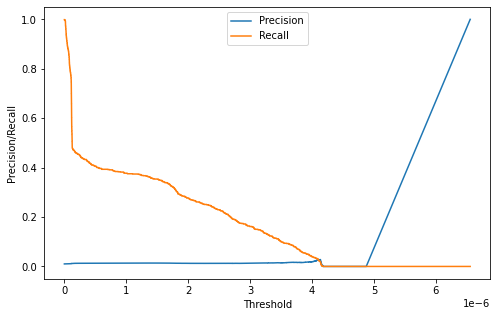

In [154]:
error_df = pd.DataFrame({'Reconstruction_error': valid_mse, 
                         'True_class':list(VALIDATION_DF_RAW['attack'])})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
#plt.show()

In [155]:
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.024858757062146894 , recall:  0.024858757062146894
threshold:  4.104809737655514e-06


In [156]:
#이동평균
mean_window = error_df['Reconstruction_error'].rolling(30, center=True).mean()
window_error = mean_window.fillna(0)
window_error

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
86395    0.0
86396    0.0
86397    0.0
86398    0.0
86399    0.0
Name: Reconstruction_error, Length: 86400, dtype: float64

Text(0.5, 0, 'Data point index')

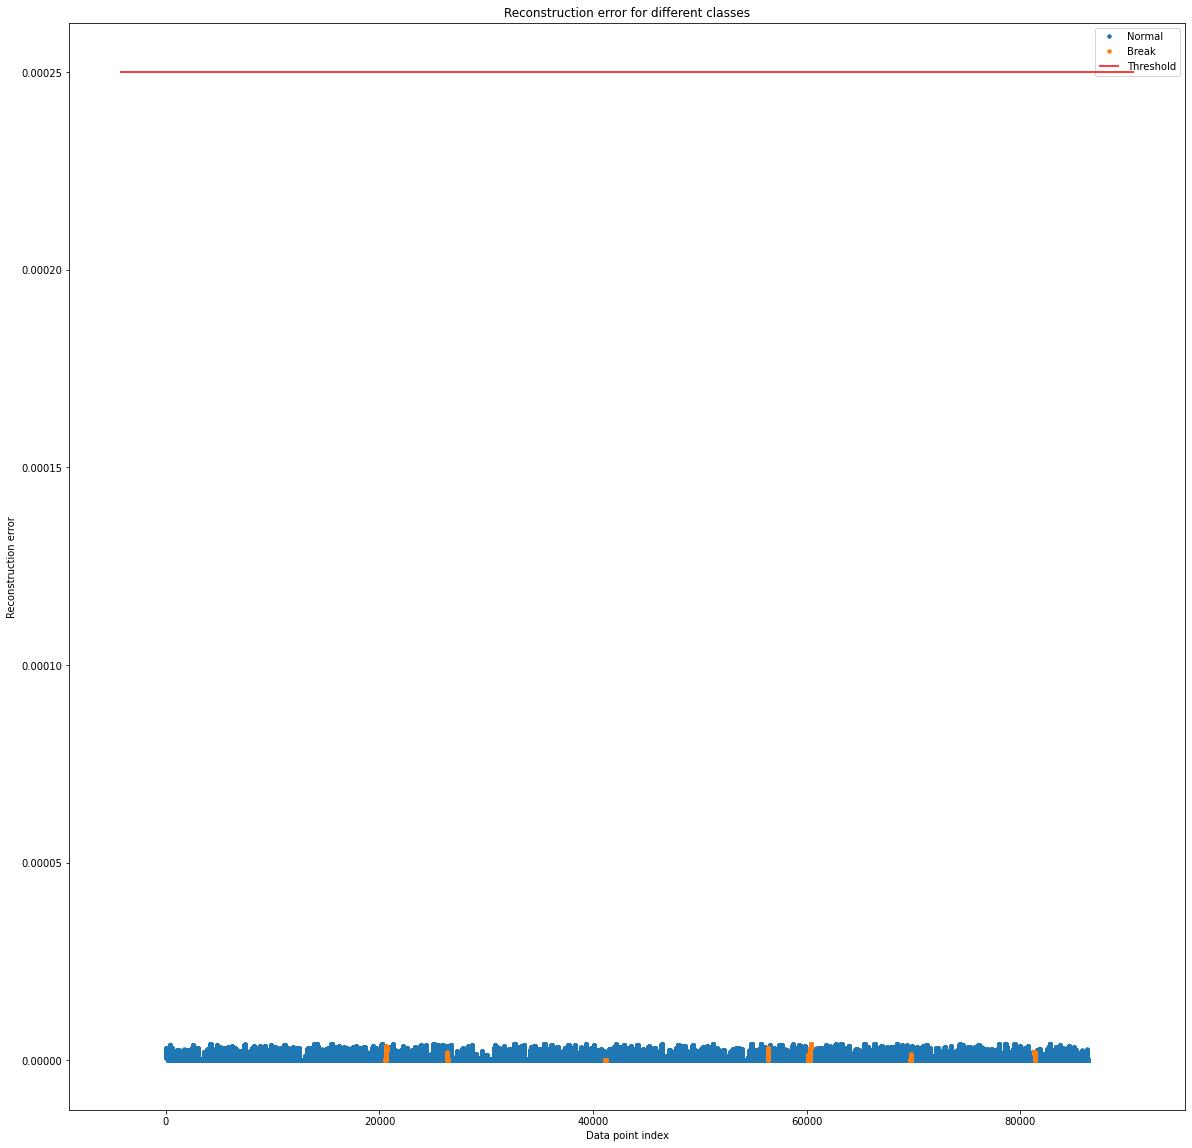

In [157]:
valid_error_df = pd.DataFrame({'Reconstruction_error': mean_window ,
                         'True_class': list(VALIDATION_DF_RAW['attack'])})
groups = valid_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
# ax.hlines(0.0025, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.hlines(0.00025, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(3, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [158]:
# valid_error_df.to_csv('./valid_anomaly_score.csv', index=False)

In [159]:
# pred_y_1 = [1 if e > 0.0025 else 0 for e in valid_error_df['Reconstruction_error'][:30000].values]
# pred_y_2 = [1 if e > 0.0012 else 0 for e in valid_error_df['Reconstruction_error'][30000:].values]
# pred_y = np.concatenate((pred_y_1, pred_y_2), axis=None)
pred_y = [1 if e > 0.00035 else 0 for e in valid_error_df['Reconstruction_error'].values]
pred_y = np.array(pred_y)
pred_y.shape

(86400,)

In [160]:
ATTACK_LABELS = np.array(VALIDATION_DF_RAW[ATTACK_FIELD])
FINAL_LABELS = np.array(pred_y)

ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [161]:
TaPR =  etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.000 (TaP: 0.000, TaR: 0.000)
# of detected anomalies: 0
Detected anomalies: []


# test

In [162]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,50,11876,11.68213,28.03598,26979,28.46628,27.40174,0,1,50,27.66017,29.02832,1,298.73773,425.30319,3609,50,16454,1.06824,1,54718,980.07202,51.53651,5.6482,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12848,48.20861,1,0.75955,0.32135,0,335.30457,425.87881,6.93170,49.85962,719.92224,1,905,0,0,144,0.18680,9.57111,9972,1,268.33344,35.0,8.72313,236.93082,229.60286,27.68860,48.60640,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,50,12094,11.68213,28.03169,26981,28.46628,27.45389,0,1,50,27.66017,29.04358,1,303.80133,425.40543,3656,50,16713,1.08312,1,54719,979.20227,52.49024,5.4256,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12896,48.17810,1,0.68719,0.32211,0,340.47668,425.87881,6.93170,49.85962,720.02686,1,905,0,0,144,0.18680,9.60827,9972,1,273.29919,35.0,8.77705,237.31230,229.60286,27.68860,48.62812,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,50,12137,11.68213,28.03251,26983,28.46628,27.49862,0,1,50,27.66017,29.04358,1,309.17242,425.40543,3676,50,17022,1.09502,1,54718,980.07202,51.53651,5.1649,0,108.60724,2880,25.66094,0,0,...,97.24579,1,0,12944,48.16284,1,0.63293,0.31906,0,348.79559,425.87881,6.93170,49.85962,720.06177,1,905,0,0,128,0.18680,9.66742,9972,1,268.33344,35.0,8.93085,237.88448,222.65125,27.68860,48.66984,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,50,12187,11.68213,28.03251,26985,28.46628,27.56569,0,1,50,27.66017,29.05884,1,313.42230,425.50763,3719,50,17233,1.11219,1,54718,981.37659,51.72729,5.1649,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12984,48.13232,1,0.61487,0.32593,0,355.12512,425.87881,6.93170,49.85962,720.06177,1,905,0,0,112,0.18680,9.70509,9972,1,269.32672,35.0,8.91705,237.88448,227.61664,27.68097,48.64198,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,50,12198,11.68213,28.03081,26979,28.46628,27.56569,0,1,50,27.66017,29.05884,1,318.25092,424.94534,3725,50,17493,1.11219,1,54718,979.63727,52.10876,4.8932,0,108.60724,2880,25.66094,0,0,...,97.25341,1,0,12696,48.11707,1,0.56064,0.32364,0,358.27185,425.87881,6.93170,49.85962,720.09613,1,906,0,0,96,0.18680,9.77965,9972,1,271.31296,35.0,8.91705,237.12160,230.59618,27.68097,48.59238,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,50,16228,18.91479,28.03953,26971,27.86075,28.35412,0,1,50,27.76649,28.95202,1,327.31122,460.57385,386,50,17966,1.04908,1,54718,1010.42865,61.45473,7.1499,0,108.24304,2880,25.68717,0,0,...,28.19976,1,0,4944,35.02502,1,36.85620,1.07132,0,318.08813,467.03854,26.76094,49.89013,719.98303,1,904,0,0,8384,0.06944,29.89865,9917,1,319.97427,35.0,14.31306,250.85446,981.37659,27.83356,49.44022,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,50,16108,19.18945,28.03953,26970,27.86075,28.47250,0,1,50,27.76649,2

In [163]:
test_bin_list = np.zeros(len(TEST_DF_RAW))
for i in range(len(TEST_DF_RAW)):
    if TEST_DF_RAW['C71'].iloc[i] > 35:
        test_bin_list[i] = 1
        test_bin_list[i-10] = 1
        test_bin_list[i+10] = 1

test_bin_list

array([0., 0., 0., ..., 0., 0., 0.])

In [164]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [165]:
boundary_check(TEST_DF)

[[0.92890173 0.16879053]
 [0.93236995 0.17375048]
 [0.93583816 0.17710797]
 ...
 [0.32254335 0.01022511]
 [0.30635837 0.01022511]
 [0.29132947 0.01022511]]


(True, False, False)

In [166]:
test = np.array(TEST_DF)
x_test = test.reshape(test.shape[0], 1, test.shape[1])
x_test.shape

(274800, 1, 2)

In [167]:
# i = 7
# x_test = x_test[:,:,i-1:i]
# x_test.shape

In [168]:
start = time.time()
test_x_predictions = model.predict(x_test)
#print(test_x_predictions)
print(test_x_predictions.shape)
#print((flatten(x_test) - flatten(test_x_predictions)).shape)
test_mse = np.mean(np.power(flatten(x_test) - flatten(test_x_predictions), 2), axis=1)
print(test_mse.shape)
print(time.time()-start)

(274800, 1, 2)
(274800,)
38.84749388694763


In [169]:
test_error = pd.DataFrame({'Reconstruction_error': test_mse})

In [170]:
move = 70
test_move = test_error['Reconstruction_error'].rolling(move, center=True).mean()

test_d = test_move.fillna(0)
test_d

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
274795    0.0
274796    0.0
274797    0.0
274798    0.0
274799    0.0
Name: Reconstruction_error, Length: 274800, dtype: float64

In [171]:
movemean_test = pd.DataFrame({'Reconstruction_error': test_d})

In [183]:
threshold = 0.000005

In [184]:
pred_y_test = [1 if e > threshold else 0 for e in movemean_test['Reconstruction_error'].values]
pred_y_test = np.array(pred_y_test)
pred_y_test.shape

(274800,)

In [185]:
# 이평안쓴거
# pred_y_test = [1 if e > treshold else 0 for e in test_error['Reconstruction_error'].values]
# pred_y_test = np.array(pred_y_test)
# pred_y_test.shape

In [186]:
submission = pd.read_csv('./HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission['attack'] = pred_y_test

In [187]:
submission['attack'].value_counts()

0    274637
1       163
Name: attack, dtype: int64

In [188]:
for i in range(len(TEST_DF_RAW)):
    if test_bin_list[i] == 1:
        pred_y_test[i] = 1

pred_y_test

array([0, 0, 0, ..., 0, 0, 0])

In [189]:
submission = pd.read_csv('./HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission['attack'] = pred_y_test

In [190]:
submission['attack'].value_counts()

0    274560
1       240
Name: attack, dtype: int64

Text(0.5, 0, 'Data point index')

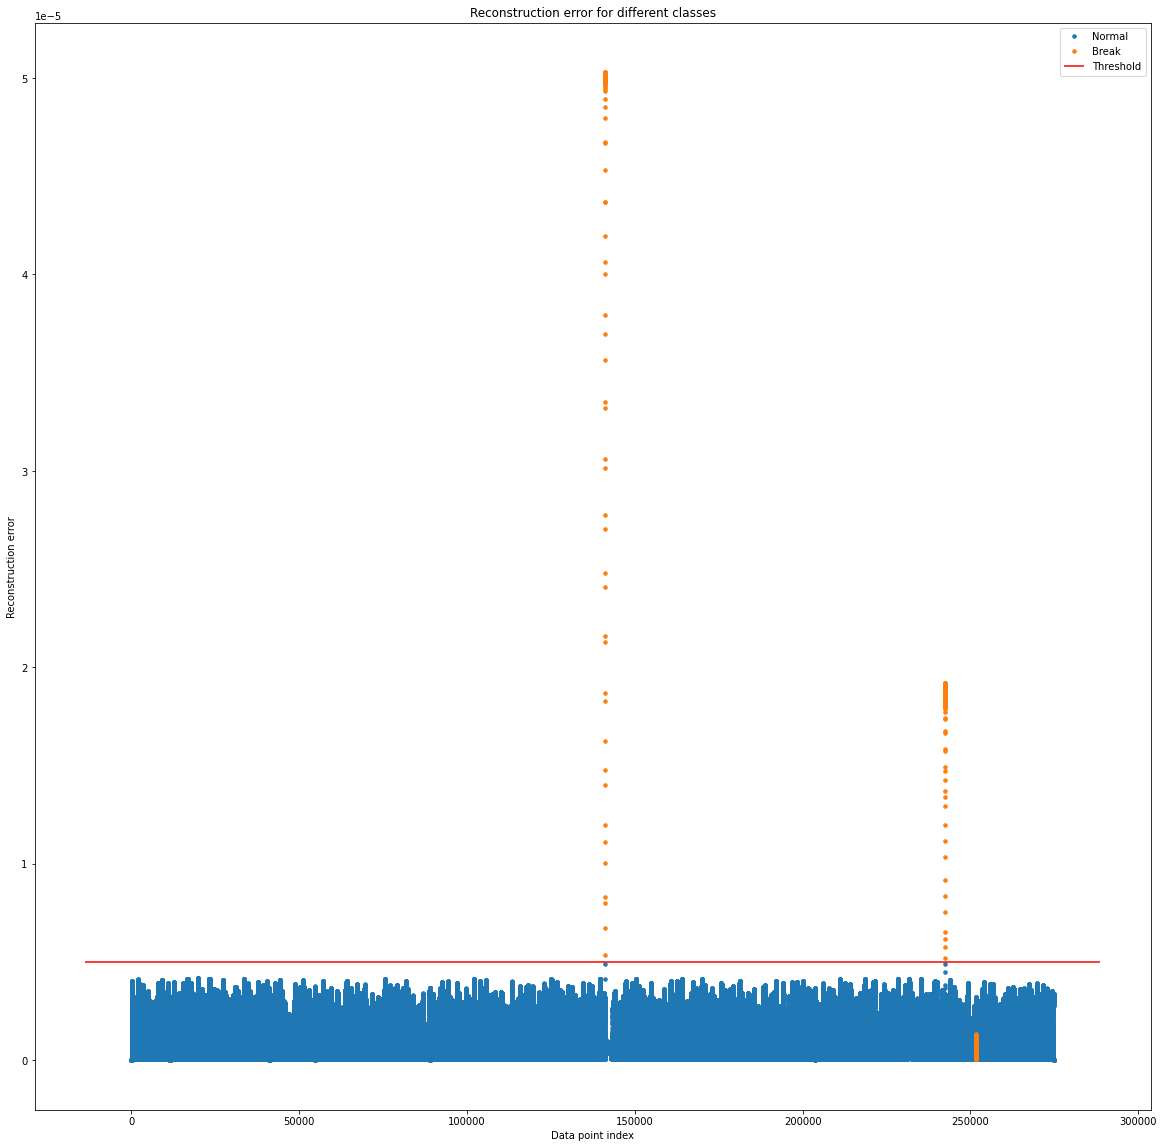

In [191]:
# test_d -> test_mse
test_error_df = pd.DataFrame({'Reconstruction_error': test_d,
                         'True_class': list(submission['attack'])})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(0.001, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.hlines(3, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [194]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
            axs[i].set_ylim(0,0.0001)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

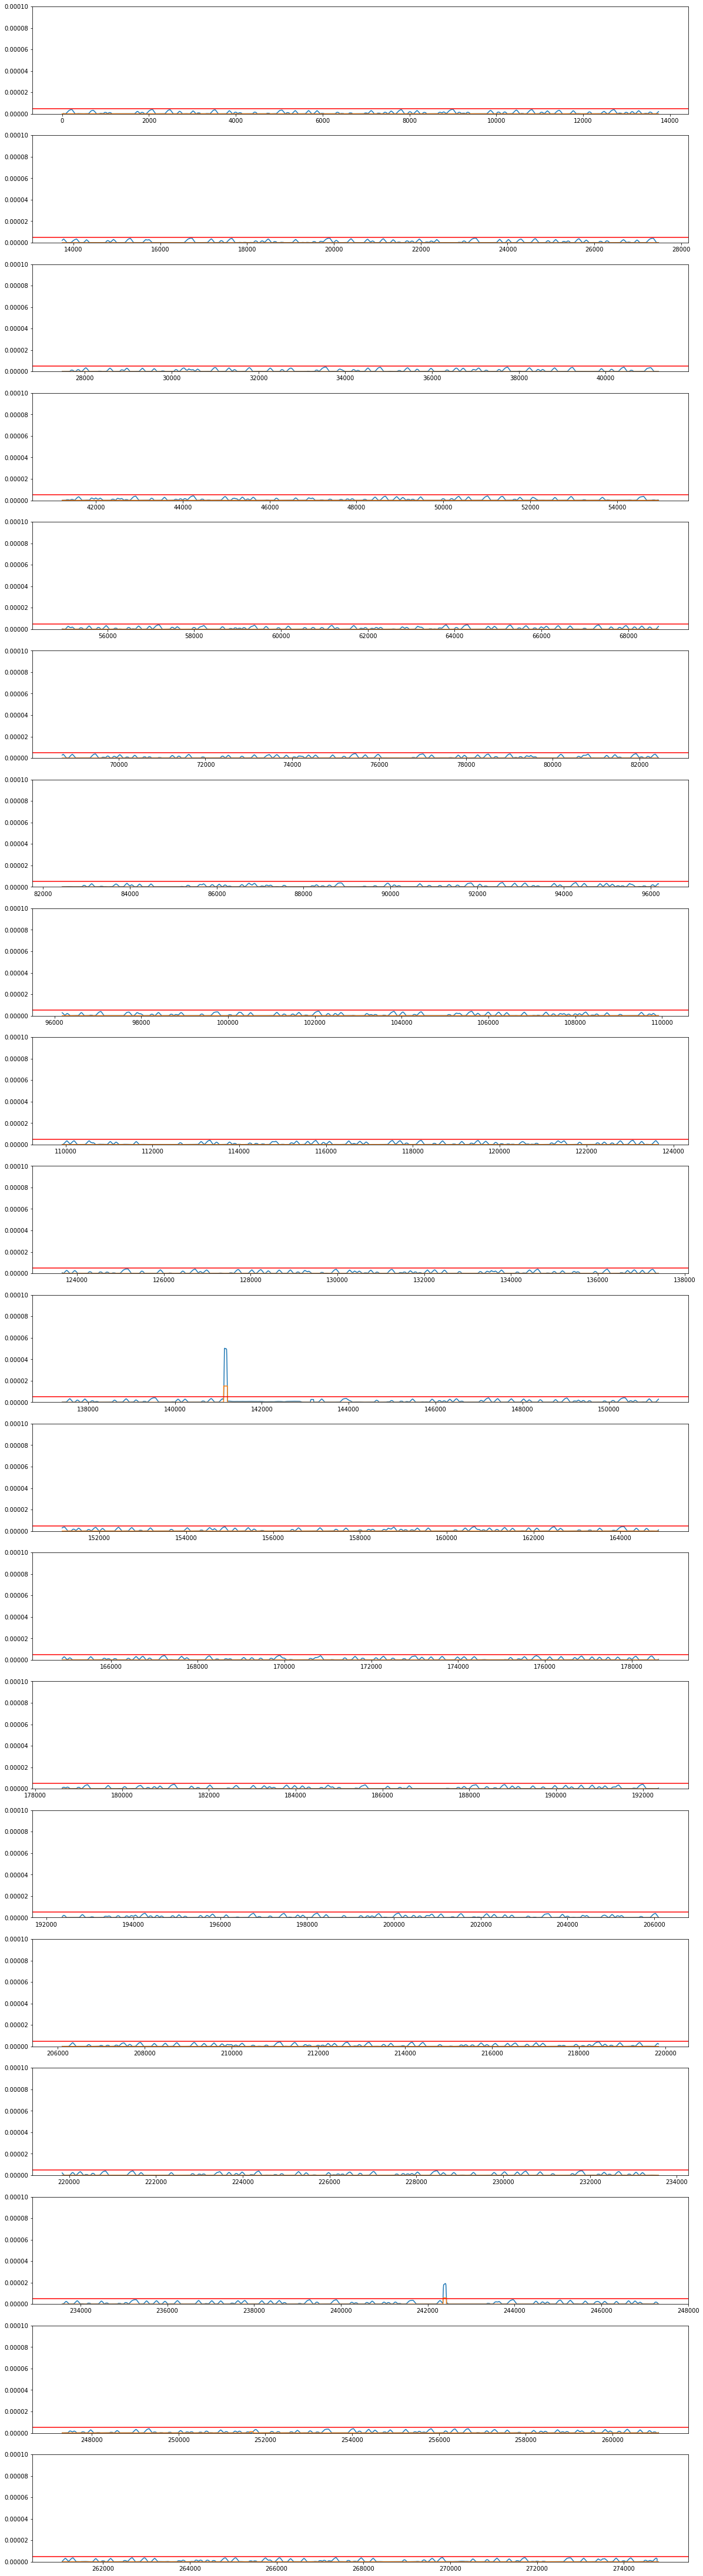

In [195]:
check_graph(test_d, submission['attack'], piece=20, THRESHOLD=threshold)

In [199]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    pred_y_test = []
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])

        #Threshold 설정
        pred_tem = [1 if e > THRESHOLD[i] else 0 for e in list(xs[L:R])]
        pred_y_test.extend(pred_tem)

        #SUBPLOT
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].title.set_text(i)
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
            axs[i].set_ylim(0,0.00005)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD[i], color='r')
    plt.show()

    pred_y_test
    pred_y_test = np.array(pred_y_test)
    return pred_y_test

In [200]:
auto_threshold = [
0.0000045,0.0000045,0.0000045,0.0000045,0.0000045,
0.0000045,0.0000045,0.0000045,0.0000045,0.0000045,
0.0000045,0.0000045,0.0000045,0.0000045,0.0000045,
0.0000045,0.0000045,0.0000045,0.0000045,0.0000045]

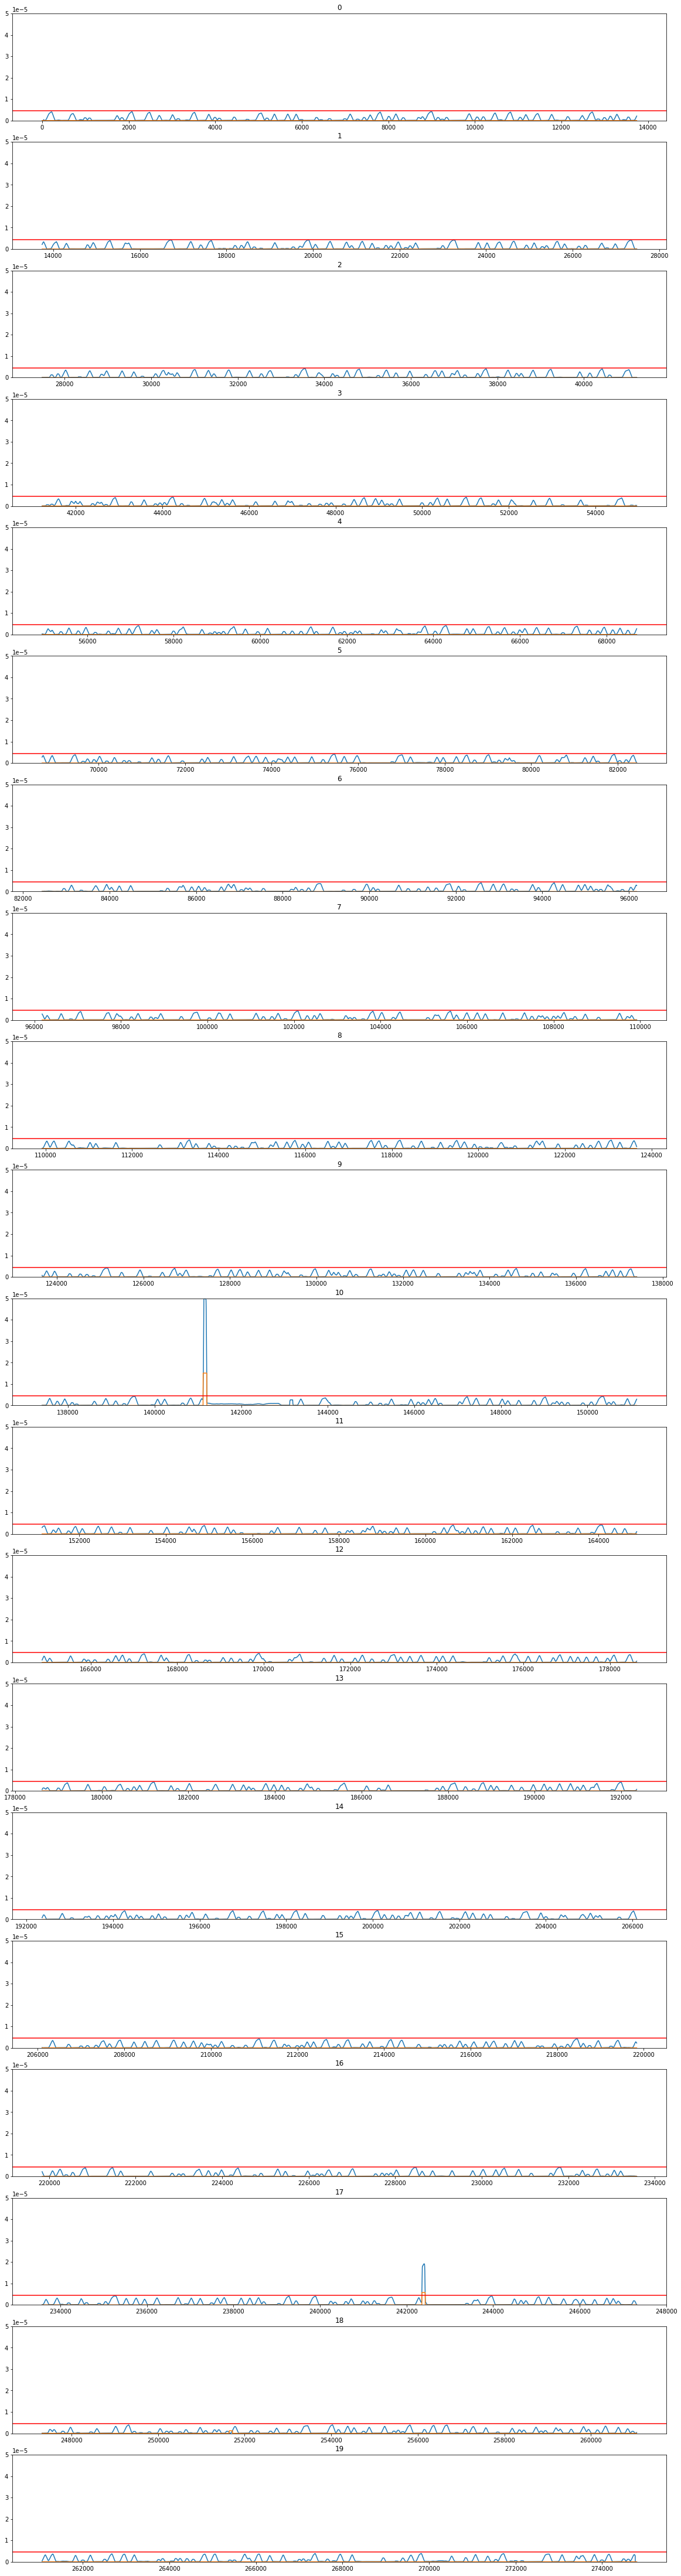

In [201]:
pred_y_test = check_graph(test_d, submission['attack'], piece=20, THRESHOLD=auto_threshold)

In [202]:
submission = pd.read_csv('./HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission['attack'] = pred_y_test

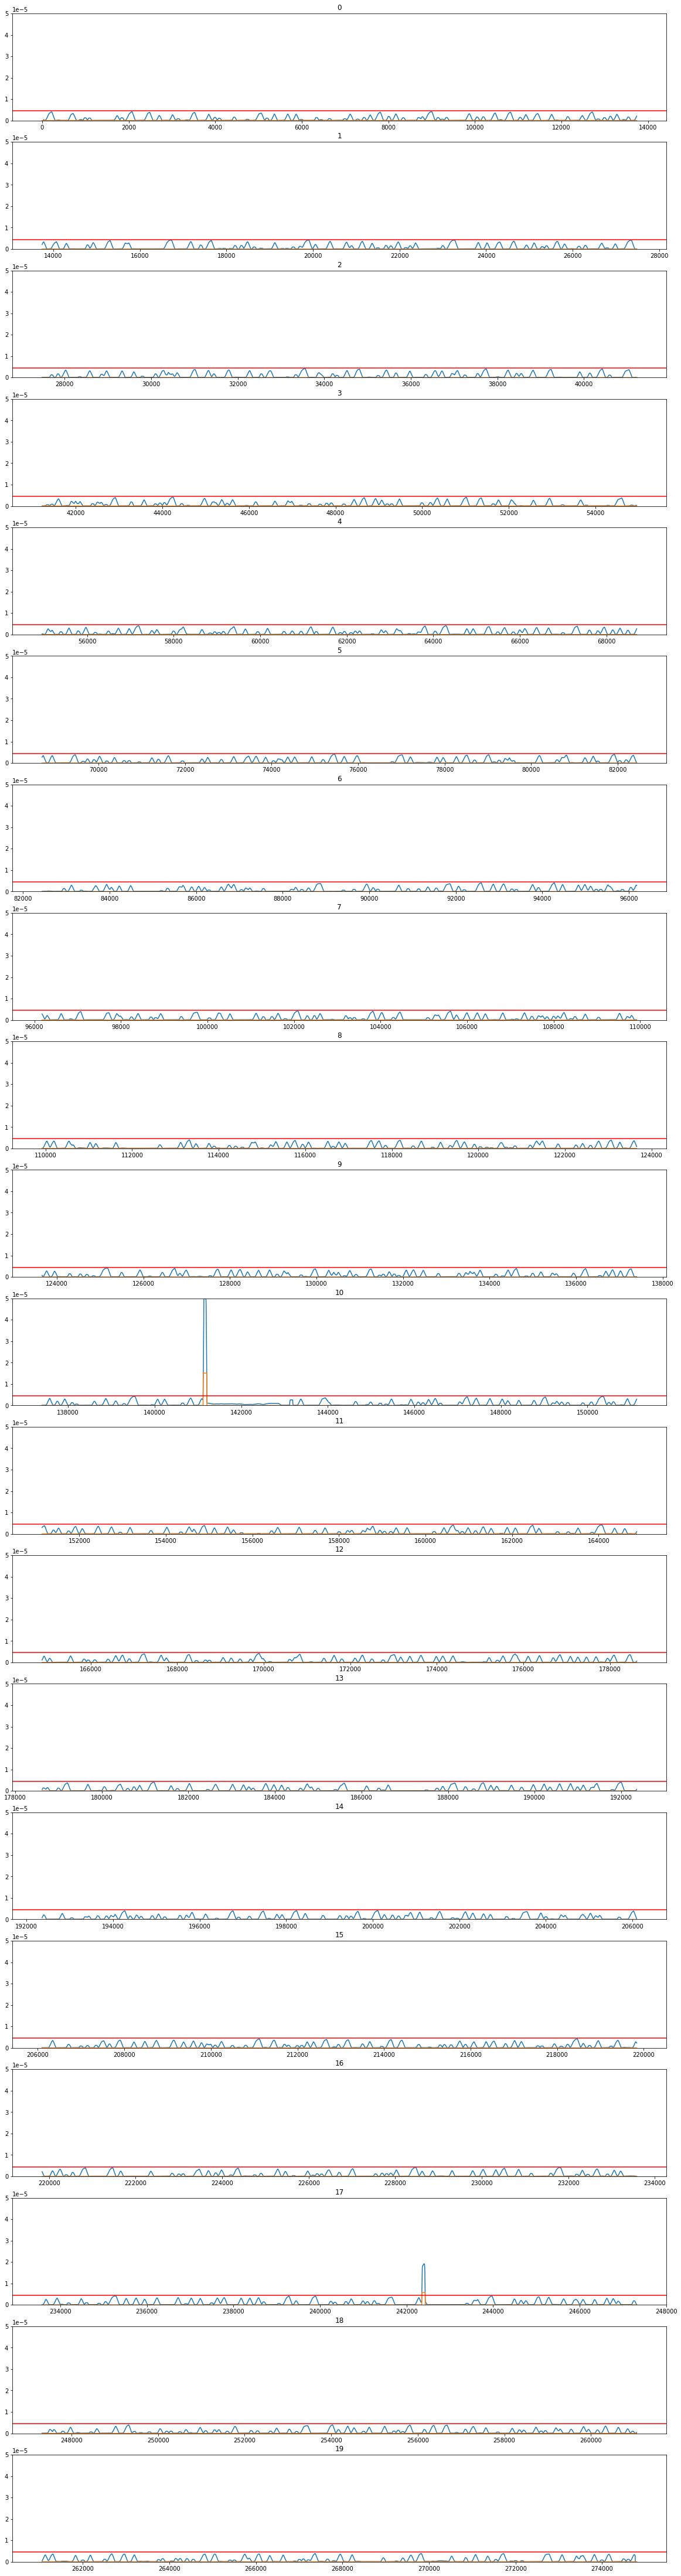

In [203]:
pred_y_test = check_graph(test_d, submission['attack'], piece=20, THRESHOLD=auto_threshold)

In [204]:
submission['attack'].value_counts()

0    274635
1       165
Name: attack, dtype: int64

In [205]:
i = str(VALID_COLUMNS_IN_TRAIN_DATASET)

In [206]:
submission.to_csv('./submit/threshold_auto_columns:%s_attack:%d_이평:%d_그룹별.csv' % 
                  (i, submission['attack'].value_counts()[1], move), index=False)